## Clean data 

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from tqdm import tqdm_notebook

from itertools import product

In [8]:
#for kaggle
# DATAPATH = '/kaggle/input/into-the-future/train.csv' 
#for my jupyter lab
DATAPATH = 'Data/train.csv' 

In [9]:
data = pd.read_csv(DATAPATH, index_col=['time'], parse_dates=['time'])
data.head(10)

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:00,0,735.740043,54479.540513
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
2019-03-19 00:01:00,6,720.406875,47835.758121
2019-03-19 00:01:10,7,712.682269,47806.938481
2019-03-19 00:01:20,8,711.509741,47812.099044


In [10]:
data.shape

(564, 3)

In [11]:
data = data[1:]
data.shape
data

,id,feature_1,feature_2
time,,,
2019-03-19 00:00:10,1,734.102947,47888.033714
2019-03-19 00:00:20,2,730.060336,47700.882325
2019-03-19 00:00:30,3,725.609742,47790.094648
2019-03-19 00:00:40,4,724.328480,47808.402381
2019-03-19 00:00:50,5,723.715893,47810.517411
...,...,...,...
2019-03-19 01:33:10,559,423.726707,54115.388787
2019-03-19 01:33:20,560,424.278568,54127.830664
2019-03-19 01:33:30,561,420.127639,54092.561194


In [12]:
# -------------do not execute------------------#
# data = data.resample('20S').mean()
# print(data.shape)
# data

I dont think we have enough data to resample. On top of that, resampling (by 30s) is removing the AR and MA component... means... after resampling...we can simply use rolling average as predictor... I not intending to submit that quality work.. 

I will have good general accuracy, but will tend to higher RMSE compared to a more tuned ARIMA

Thus we shall not resample...

## Exploratory data analysis (EDA)

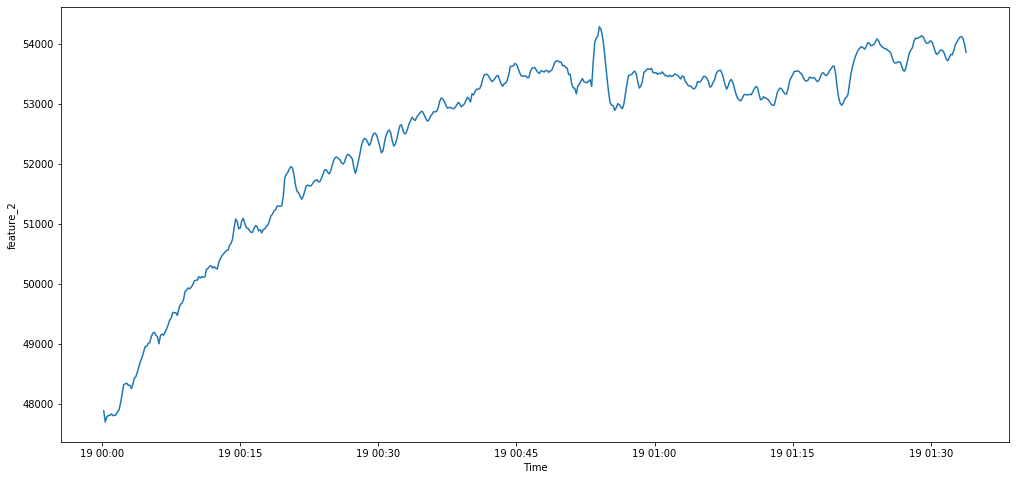

In [13]:
plt.figure(figsize=(17, 8))
plt.plot(data.feature_2)
plt.ylabel('feature_2')
plt.xlabel('Time')
plt.grid(False)
plt.show()

### Moving average

In [14]:
def plot_moving_average(series, window):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')       
#     plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)

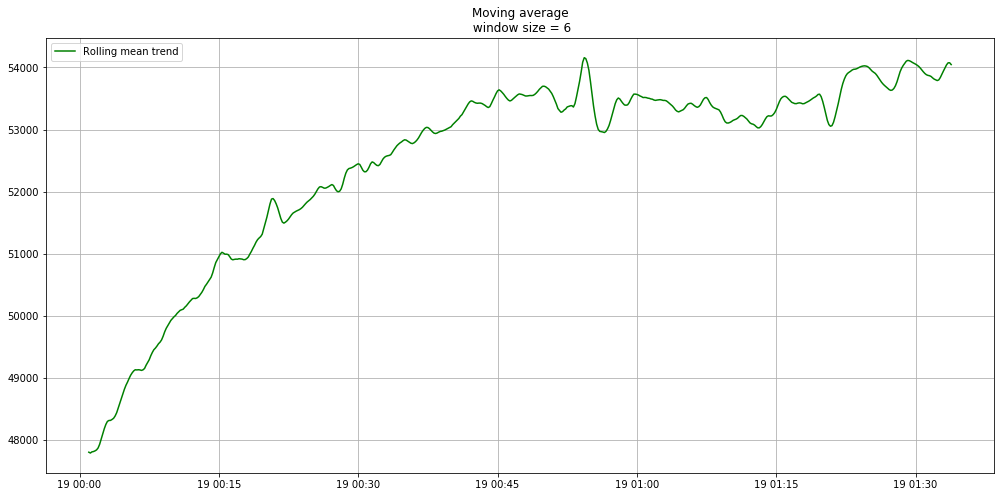

In [15]:
#Smooth by the previous 6 reading (10 seconds/1min)
plot_moving_average(data.feature_2,6)

## Decomp to understand Seasonality

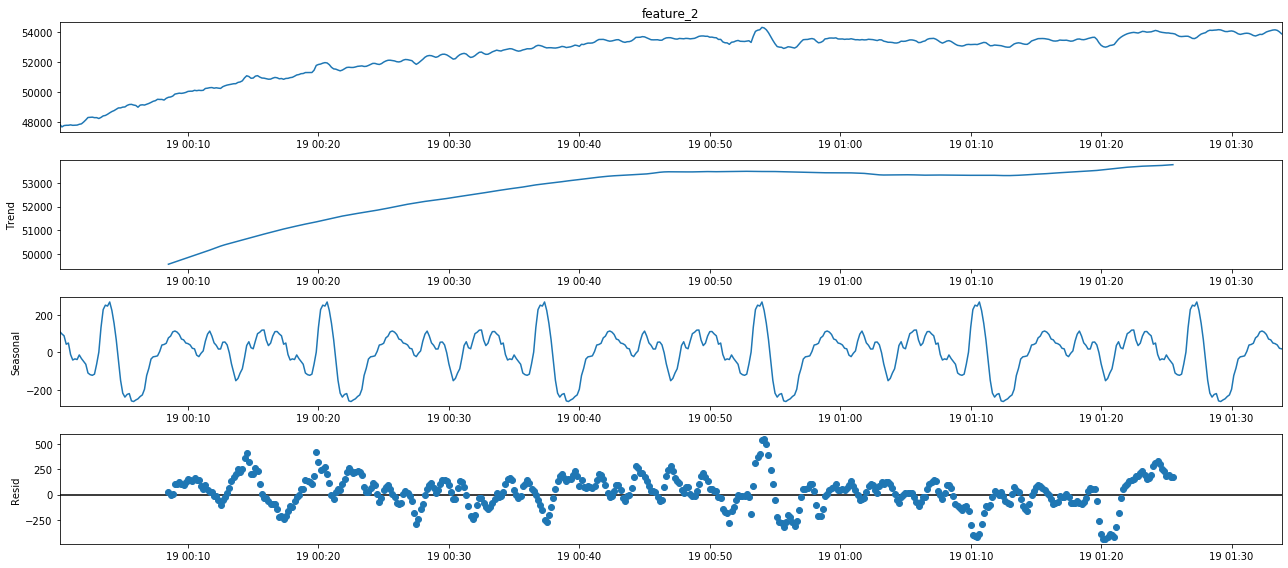

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data.feature_2, model='additive', period=100)
fig = decomposition.plot()
plt.show()

Quenstion needs answering

With increase in seasonality there is an increase in residuals also... so there can be increasing seasonality doesnt reduce reseduals... this seasonality is being extracted at the cost of residual ?

## Stationarity 

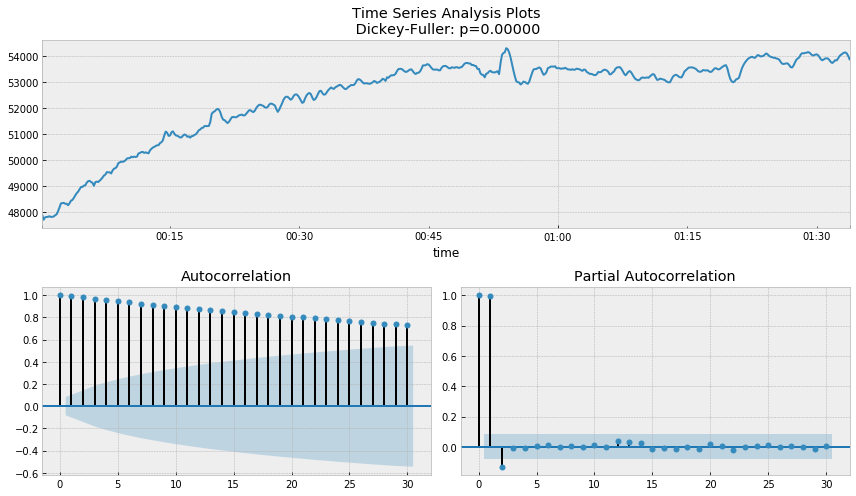

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.feature_2, lags=30)

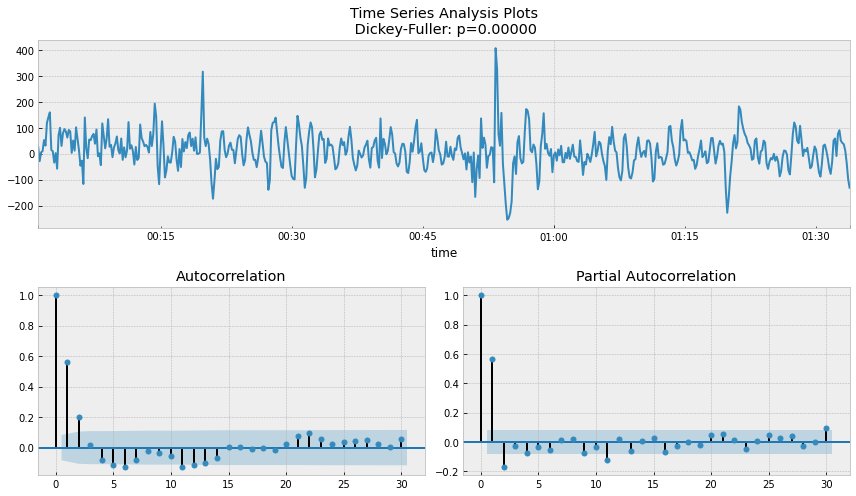

In [13]:
data_diff = data.feature_2 - data.feature_2.shift(1)

tsplot(data_diff[5:], lags=30)

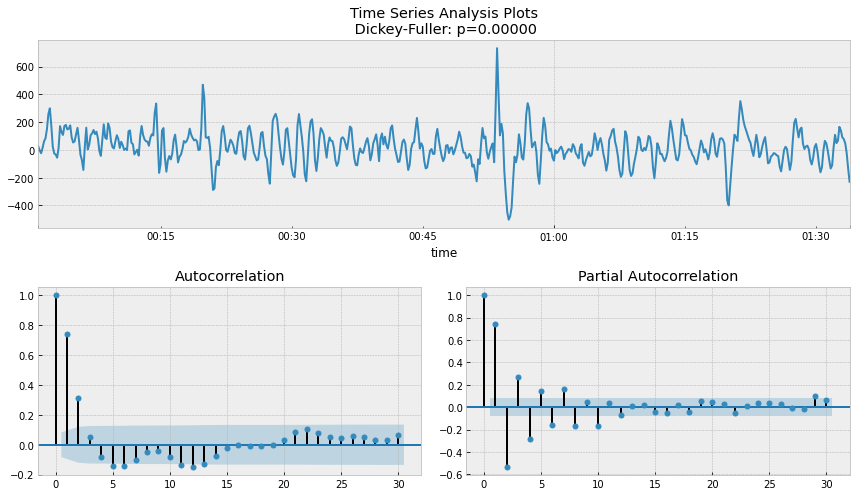

In [14]:
data_diff = data.feature_2 - data.feature_2.shift(2)

tsplot(data_diff[5:], lags=30)

at d = 2 -> q acts funny... I am a little unware when this situation arises

#### Predicted readings from the ACF and PACF graphs

* p-val = 0-2
* d = 1 or 2
* q = 0-2

## ARIMA

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
#Set initial values and some bounds
ps = range(0, 1+1)
d = range(1,2+1)
qs = range(0, 2+1)

#Create a list with all possible combinations of parameters
parameters = product(ps, d, qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [17]:
def optimize_ARIMA(parameters_list):
    
    results = []
    best_aic = float('inf')
    
    for p in parameters_list:
        try: model = ARIMA(data.feature_2, order=(p[0],p[1],p[2])).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        print(aic)
        
        #Save best model, AIC and peters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_p = p
        results.append([p, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_ARIMA(parameters_list)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/

6361.312133082529
6171.50377701899
6151.04025058831
6281.743901707521
6274.656697763396


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


6162.479894006567
6158.366954607596
6147.327454542037


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/

6148.988902220457
6278.810063338749


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


6152.016939279089


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


6140.487136629914


In [18]:
result_table

,parameters,aic
0,"(1, 2, 2)",6140.487137
1,"(1, 1, 1)",6147.327455
2,"(1, 1, 2)",6148.988902
3,"(0, 1, 2)",6151.040251
4,"(1, 2, 1)",6152.016939
5,"(1, 1, 0)",6158.366955
6,"(0, 2, 2)",6162.479894
7,"(0, 1, 1)",6171.503777
8,"(0, 2, 1)",6274.656698
9,"(1, 2, 0)",6278.810063


In [19]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)

p,d, q = result_table.parameters[0]

best_model = ARIMA(data.feature_2, order=(p, d, q)).fit(disp=-1)

print(best_model.summary())

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 10S will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:           D2.feature_2   No. Observations:                  561
Model:                 ARIMA(1, 2, 2)   Log Likelihood               -3065.244
Method:                       css-mle   S.D. of innovations             56.838
Date:                Wed, 15 Jul 2020   AIC                           6140.487
Time:                        06:56:40   BIC                           6162.136
Sample:                    03-19-2019   HQIC                          6148.940
                         - 03-19-2019                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0587      0.030     -1.976      0.048      -0.117      -0.000
ar.L1.D2.feature_2     0.3732      0.068      5.506      0.000       0.240       0.506
ma.L1.D2.feature_2  

Problem with AR, need to check. Lets use simple MA
Cant Achieve Stationarity

## Making Prediction

In [1]:
old = list(data['feature_2'].values)
len(old)

NameError: name 'data' is not defined

In [22]:
def make_pred(array=old, steps=375):
    l=len(array)
    for i in range(1,steps+1):
        pos=len(array)
        sum=0
        for j in range(pos-10,pos):
            sum = sum + array[j]
        array.append(sum/10)
    return array

In [23]:
new = make_pred(old,375)
new=new[563:]

In [26]:
sol = pd.DataFrame()
sol['feature_2'] = new
sol.index =[i for i in range(564,(564+375))]
sol.index.name = 'id'
sol.to_csv("last_try.csv")

I am getting a score of 600 with simple MA


I am pretty With Auto regression component & proper singularity we can achieve much better results

# Solving using fbprohet

Since I was not being able to achieve staionarity, I decided to read up online.

Things we were aware of : 
1. Primary challenege in ARIMA(p,d,q) is to determine p,d,q accuaretly. 
2. We can see there is no seasonality.
3. I have got a score of ~600 (rmse) by using simple MA (10 days), tuning it for other lags would result in a slightly better score!
4. Moreover, It can be drastically improved by including a Auto Regression component. 
5. For auto regression we need to get staionarity, removing of trend from the graph. 
6. Stationarity is where our model faulted. (d-value)
5. From suggestions online, I have decided to go ahead with building an fbprophet model, as it is a self staionrizing model. 

https://facebook.github.io/prophet/docs/trend_changepoints.html#automatic-changepoint-detection-in-prophet
https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

Before I go ahead I need to add another speculation, I am again not entirely sure of this, need to check this. I am speculating that the ARIMA model can remove trend only whent the trend is linear, since "I" component of ARIMA used an diffentiating component 'd'

Again this need to be checked and if anyone knows the answers please feel free to comment. I am going to dive into the depth of derivation of ARIMA to determine if I am true on not. Understand how the model tranforms the data to stionarity. 

I am 100% sure that autoregression has the same limitations as linear modeling 

PS:
Stationarity doesnt only mean removing the trend, it also means removing co-varience and homeoskedacity..etc 

### fbprohet is a model built by facebook!

In [6]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [ ]:
data_fb = data[['feature_2']].reset_index()
data_fb.columns = ['ds','y']
data_fb

In [ ]:
model = Prophet()
model.fit(data_fb)

test = model.make_future_dataframe(periods=375, freq='10S')
pred = model.predict(test)
pred.head()

In [ ]:
solution2=pred[564:]['yhat']

In [ ]:
solution2.to_csv("Solution_fb.csv")

In [33]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, horizon = '900 seconds')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-03-19 01:18:50 and 2019-03-19 01:18:50


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-03-19 01:19:00,53318.160986,53116.066698,53513.716085,53554.099087,2019-03-19 01:18:50
1,2019-03-19 01:19:10,53317.944903,53094.083153,53517.678705,53589.463104,2019-03-19 01:18:50
2,2019-03-19 01:19:20,53317.728819,53122.115432,53511.824560,53628.195154,2019-03-19 01:18:50
3,2019-03-19 01:19:30,53317.512736,53119.023480,53527.403297,53634.896462,2019-03-19 01:18:50
4,2019-03-19 01:19:40,53317.296652,53123.560800,53512.421429,53500.573364,2019-03-19 01:18:50


In [35]:
mean_squared_error()

TypeError: mean_squared_error() missing 2 required positional arguments: 'y_true' and 'y_pred'